In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import getpass

### Extract Data from SQL Database

In [3]:
def get_db_config():
    host = input("Enter the database host (default: localhost): ") or 'localhost'
    user = input("Enter your database username (default: root): ") or 'root'
    password = getpass.getpass("Enter your database password: ")
    database = 'financial_data'

    return {
        'host': host,
        'user': user,
        'password': password,
        'database': database
    }

def fetch_data_from_sql(db_config, tickers):
    connection = mysql.connector.connect(**db_config)
    cursor = connection.cursor()

    dataframes = {}
    for name in tickers:
        query = f"SELECT * FROM {name.replace(' ', '_')};"
        cursor.execute(query)
        columns = [col[0] for col in cursor.description]
        data = cursor.fetchall()
        dataframes[name] = pd.DataFrame(data, columns=columns)

    cursor.close()
    connection.close()
    return dataframes

tickers = {
    'GOLD_FUTURES': 'GC=F', 
    'SP_INDEX': '^GSPC',
    'DJ_INDEX': '^DJI',
    'EG_CORP': 'EGO',
    'EUR_USD': 'EURUSD=X',
    'OIL_FUTURES': 'BZ=F',
    'WTI_OIL': 'CL=F',
    'SILVER_FUTURES': 'SI=F',
    'US_BOND_RATE': '^TNX',
    'PLATINUM_FUTURES': 'PL=F',
    'PALLADIUM_FUTURES': 'PA=F',
    'GOLD_MINERS': 'GDX',
    'OIL_ETF': 'USO',
    'USD_INDEX': 'DX-Y.NYB'
}

db_config = get_db_config()
dataframes = fetch_data_from_sql(db_config, tickers)
all_data = pd.DataFrame()

for name, df in dataframes.items():
    df.to_csv(f"{name}.csv", index=False)
    print(f"Saved {name} data to {name}.csv.")

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    df = df[['Close']].rename(columns={'Close': name})
    
    if all_data.empty:
        all_data = df
    else:
        all_data = all_data.join(df, how='outer', lsuffix='_left', rsuffix='_right')

all_data.dropna(inplace=True)

all_data.to_csv("all_tickers_data.csv", index=True)
print("Data saved to 'all_tickers_data.csv'.")

Enter the database host (default: localhost):  localhost
Enter your database username (default: root):  root
Enter your database password:  ········


Saved GOLD_FUTURES data to GOLD_FUTURES.csv.
Saved SP_INDEX data to SP_INDEX.csv.
Saved DJ_INDEX data to DJ_INDEX.csv.
Saved EG_CORP data to EG_CORP.csv.
Saved EUR_USD data to EUR_USD.csv.
Saved OIL_FUTURES data to OIL_FUTURES.csv.
Saved WTI_OIL data to WTI_OIL.csv.
Saved SILVER_FUTURES data to SILVER_FUTURES.csv.
Saved US_BOND_RATE data to US_BOND_RATE.csv.
Saved PLATINUM_FUTURES data to PLATINUM_FUTURES.csv.
Saved PALLADIUM_FUTURES data to PALLADIUM_FUTURES.csv.
Saved GOLD_MINERS data to GOLD_MINERS.csv.
Saved OIL_ETF data to OIL_ETF.csv.
Saved USD_INDEX data to USD_INDEX.csv.
Data saved to 'all_tickers_data.csv'.


### Exploratory Data Analysis (EDA)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2007-07-30,659.9000,665.2000,659.3000,664.1,664.1,36526
1,2007-07-31,665.0000,668.3000,662.6000,666.9,666.9,5769
2,2007-08-01,663.2000,666.3000,658.5000,663.6,663.6,2026
3,2007-08-02,666.7000,666.7000,662.8000,664.6,664.6,1062
4,2007-08-03,665.8000,674.4000,665.7000,672.5,672.5,575
...,...,...,...,...,...,...,...
4348,2024-11-08,2688.5000,2694.6001,2682.8999,2687.5,2687.5,1038
4349,2024-11-11,2671.7000,2671.7000,2611.2000,2611.2,2611.2,20
4350,2024-11-12,2605.5000,2605.5000,2592.8000,2600.0,2600.0,118
4351,2024-11-13,2611.1001,2611.8000,2580.8000,2580.8,2580.8,53


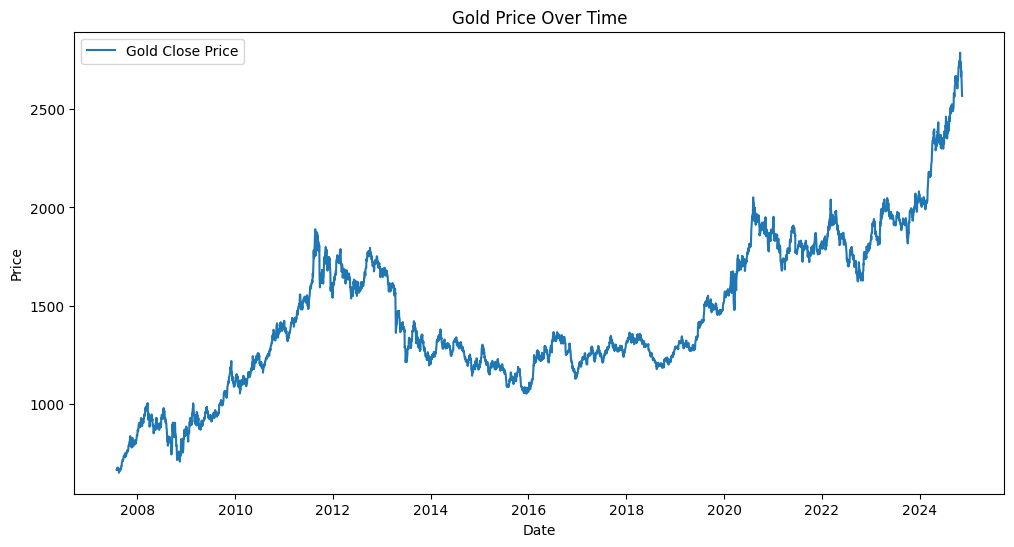

In [5]:
# Load GOLD_ETF data
gold_data = pd.read_csv("GOLD_FUTURES.csv")
display(gold_data)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data.set_index('Date', inplace=True)

# Plot gold price trends
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Close'], label='Gold Close Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Correlation Analysis

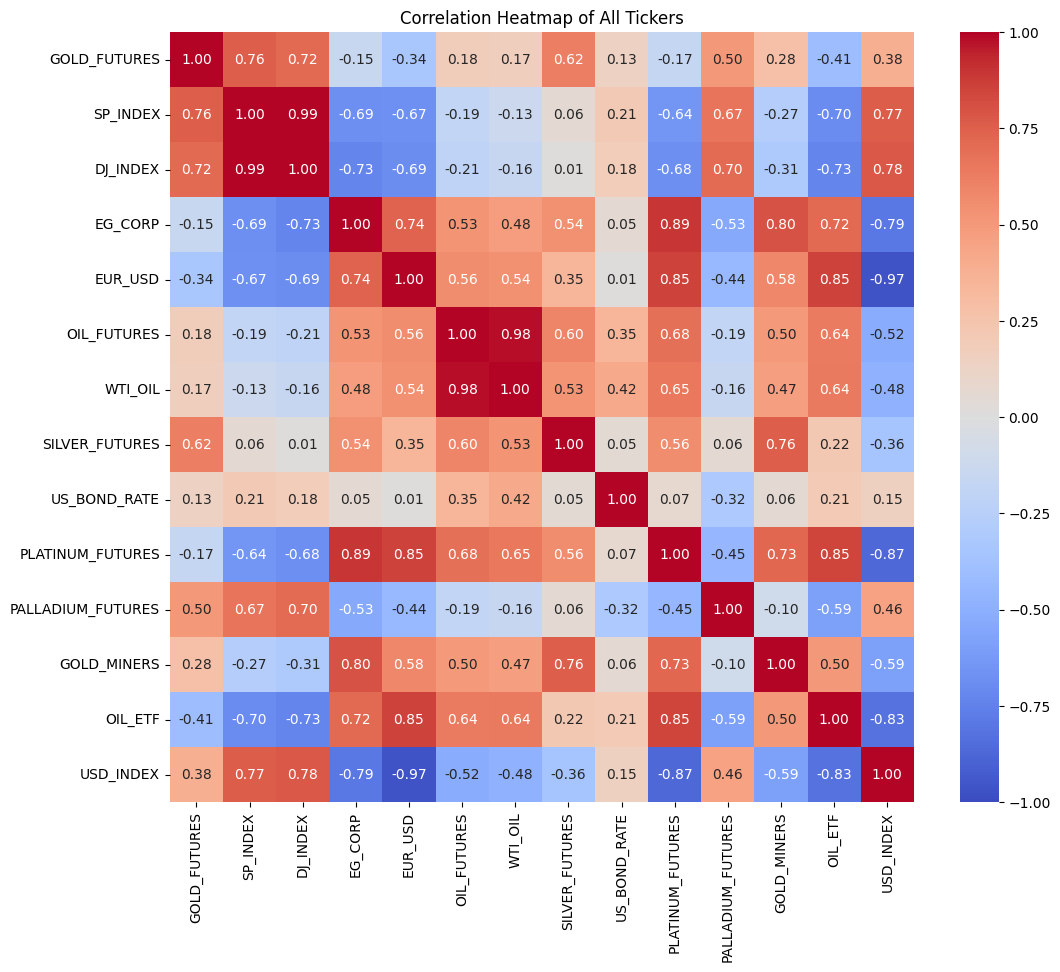

In [6]:
correlation_matrix = all_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of All Tickers')
plt.show()

Seasonal Decomposition

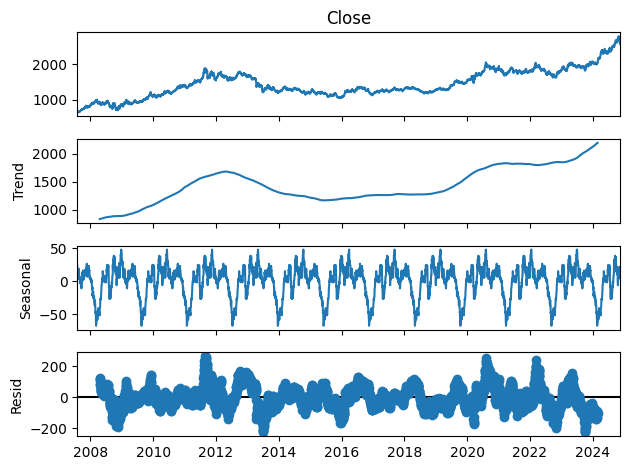

In [7]:
# Decompose gold prices
decomposition = seasonal_decompose(gold_data['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

### Feature Engineering

##### **Add Lagged Features**

Lagged features are often used in time series models to incorporate previous values of a variable into predicting future values. For example, the closing price from the previous day can be used to predict today's price.



In [8]:
def create_lagged_features(df, tickers, lag_days=1):
    for ticker in tickers:
        for lag in range(1, lag_days+1):
            df[f'{ticker}_lag_{lag}'] = df[ticker].shift(lag)
    return df

market_tickers = [col for col in all_data.columns if col != 'GOLD_FUTURES']

all_data = create_lagged_features(all_data, ['GOLD_FUTURES'] + market_tickers, lag_days=3)

all_data.head()

,GOLD_FUTURES,SP_INDEX,DJ_INDEX,EG_CORP,EUR_USD,OIL_FUTURES,WTI_OIL,SILVER_FUTURES,US_BOND_RATE,PLATINUM_FUTURES,...,PALLADIUM_FUTURES_lag_3,GOLD_MINERS_lag_1,GOLD_MINERS_lag_2,GOLD_MINERS_lag_3,OIL_ETF_lag_1,OIL_ETF_lag_2,OIL_ETF_lag_3,USD_INDEX_lag_1,USD_INDEX_lag_2,USD_INDEX_lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-30,665.0000,1457.6400,13238.7305,23.9500,1.3642,71.9000,73.3600,11.7910,4.5020,1260.1000,...,None,None,None,None,None,None,None,None,None,None
2007-08-31,673.0000,1473.9900,13357.7402,24.8500,1.3642,72.6900,74.0400,12.0630,4.5370,1271.6000,...,None,36.5100,None,None,444.0000,None,None,80.7900,None,None
2007-09-04,682.5000,1489.4200,13448.8604,25.8000,1.3620,73.9200,75.0800,12.2810,4.5580,1273.7000,...,None,37.6500,36.5100,None,446.2400,444.0000,None,80.7900,80.7900,None
2007-09-05,681.7000,1472.2900,13305.4697,26.0000,1.3654,74.3400,75.7300,12.1900,4.4730,1273.0000,...,330.7000,38.6600,37.6500,36.5100,454.0000,446.2400,444.0000,80.8800,80.7900,80.7900
2007-09-06,695.6000,1478.5500,13363.3496,27.0000,1.3696,74.7700,76.3000,12.3650,4.5000,1288.9000,...,333.5000,38.4800,38.6600,37.6500,458.0800,454.0000,446.2400,80.6200,80.8800,80.7900


##### **Rolling Statistics (Moving Averages & Volatility)**

To capture the trend of gold prices over a window of time

Models trained with moving averages can understand market trends better, leading to more accurate predictions.

Volatility features provide context for price changes, helping models anticipate sharp movements.

Rolling statistics smooth out noise, making it easier for models to learn meaningful patterns.

In [9]:
def create_rolling_features(df, tickers, window_sizes=[7, 30]):
    for ticker in tickers:
        for window in window_sizes:
            # Moving Average
            df[f'{ticker}_MA_{window}'] = df[ticker].rolling(window=window).mean()
            # Volatility (Standard Deviation)
            df[f'{ticker}_Volatility_{window}'] = df[ticker].rolling(window=window).std()
    return df

all_data = create_rolling_features(all_data, ['GOLD_FUTURES'] + market_tickers)
all_data.dropna(inplace=True)

display(all_data)

,GOLD_FUTURES,SP_INDEX,DJ_INDEX,EG_CORP,EUR_USD,OIL_FUTURES,WTI_OIL,SILVER_FUTURES,US_BOND_RATE,PLATINUM_FUTURES,...,GOLD_MINERS_MA_30,GOLD_MINERS_Volatility_30,OIL_ETF_MA_7,OIL_ETF_Volatility_7,OIL_ETF_MA_30,OIL_ETF_Volatility_30,USD_INDEX_MA_7,USD_INDEX_Volatility_7,USD_INDEX_MA_30,USD_INDEX_Volatility_30
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-14,998.2000,1288.1400,11951.0898,37.5000,1.5618,106.2000,110.2100,20.5740,3.4210,2051.0000,...,46.851667,6.411580,685.977143,11.304533,554.578667,98.453713,72.632857,0.599492,76.971333,3.343926
2008-03-17,1001.4000,1276.6000,11972.2500,37.0000,1.5748,101.7500,105.6800,20.2220,3.3140,1948.4000,...,47.467000,6.269083,685.302857,12.423781,561.992000,98.213089,72.412857,0.713949,76.660333,3.409744
2008-03-18,1003.2000,1330.7400,12392.6602,37.5000,1.5658,105.5600,109.4200,19.8900,3.4510,1943.0000,...,47.958333,6.046831,687.668571,10.400557,569.997333,98.240518,72.204286,0.716865,76.353000,3.440068
2008-03-19,944.7000,1298.4200,12099.6602,34.2000,1.5639,100.7200,104.4800,18.3950,3.3620,1862.0000,...,48.315333,5.789620,683.851429,15.283241,576.808000,96.996043,72.082857,0.628085,76.061667,3.413449
2008-03-20,919.6000,1329.5100,12361.3203,32.6000,1.5442,100.3800,101.8400,16.8050,3.3280,1852.3000,...,48.625333,5.485847,678.091429,19.326330,583.218667,95.217588,72.007143,0.472360,75.799333,3.352928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08,2687.5000,5995.5400,43988.9883,16.6500,1.0795,73.8700,70.3800,31.3590,4.3060,973.6000,...,40.651333,1.452415,73.778571,1.042808,73.748000,2.294989,104.310000,0.605915,103.437667,1.064080
2024-11-11,2611.2000,6001.3501,44293.1289,15.5500,1.0715,71.8300,68.0400,30.5400,4.3080,964.3000,...,40.548333,1.613982,73.472857,1.496660,73.782000,2.243296,104.532857,0.737015,103.596333,1.007508
2024-11-12,2600.0000,5983.9902,43910.9805,15.3700,1.0664,71.8900,68.1200,30.6860,4.4320,942.9000,...,40.403667,1.806163,73.282857,1.771099,73.734667,2.294195,104.781429,0.910521,103.757333,0.995562


##### **Normalization/Scaling**

The features (independent variables) that are used to predict the target (gold prices) can have different scales (e.g., oil prices in USD, S&P 500 index values, volatility measures, etc.). Normalizing these features ensures that:

--> All the features contribute equally to the model, preventing any single feature (like oil prices) from dominating due to its larger scale.

--> It stabilizes the training process and reduces the risk of model bias towards large-scale features.

The value of the gold price is on its own scale and needs to be predicted in this same scale (e.g., dollars per ounce).

In [10]:
from sklearn.preprocessing import StandardScaler

# features to normalize (all columns except the target gold prices)
features_to_scale = [col for col in all_data.columns if col != 'GOLD_FUTURES']

scaler = StandardScaler()
all_data[features_to_scale] = scaler.fit_transform(all_data[features_to_scale])
display(all_data)

,GOLD_FUTURES,SP_INDEX,DJ_INDEX,EG_CORP,EUR_USD,OIL_FUTURES,WTI_OIL,SILVER_FUTURES,US_BOND_RATE,PLATINUM_FUTURES,...,GOLD_MINERS_MA_30,GOLD_MINERS_Volatility_30,OIL_ETF_MA_7,OIL_ETF_Volatility_7,OIL_ETF_MA_30,OIL_ETF_Volatility_30,USD_INDEX_MA_7,USD_INDEX_Volatility_7,USD_INDEX_MA_30,USD_INDEX_Volatility_30
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-14,998.2000,-1.110278,-1.175105,0.338440,3.023025,1.144696,1.745551,-0.184034,0.994415,2.887402,...,1.199091,4.097871,4.469989,0.909387,3.331031,4.414098,-2.021486,0.486350,-1.560283,3.954915
2008-03-17,1001.4000,-1.119534,-1.172758,0.319917,3.130697,0.962427,1.538152,-0.240070,0.879004,2.554522,...,1.250075,3.978286,4.464290,1.040496,3.393387,4.402312,-2.044687,0.832382,-1.593193,4.061328
2008-03-18,1003.2000,-1.076108,-1.126145,0.338440,3.056155,1.118482,1.709382,-0.292921,1.026773,2.537002,...,1.290785,3.791771,4.484283,0.803495,3.460723,4.403656,-2.066683,0.841196,-1.625715,4.110355
2008-03-19,944.7000,-1.102032,-1.158632,0.216186,3.040418,0.920239,1.483212,-0.530913,0.930777,2.274201,...,1.320365,3.575917,4.452024,1.375455,3.518010,4.342702,-2.079489,0.572793,-1.656544,4.067318
2008-03-20,919.6000,-1.077095,-1.129620,0.156912,2.877253,0.906313,1.362343,-0.784027,0.894104,2.242730,...,1.346050,3.320988,4.403347,1.849064,3.571932,4.255594,-2.087474,0.102000,-1.684303,3.969468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08,2687.5000,2.665562,2.377114,-0.433983,-0.971620,-0.179520,-0.078007,1.532845,1.948982,-0.608165,...,0.685353,-0.063898,-0.703651,-0.292676,-0.713398,-0.295698,1.319198,0.505770,1.240367,0.268927
2024-11-11,2611.2000,2.670223,2.410836,-0.474734,-1.037880,-0.263077,-0.185140,1.402467,1.951139,-0.638338,...,0.676819,0.071691,-0.706234,-0.239511,-0.713112,-0.298230,1.342700,0.902114,1.257157,0.177463
2024-11-12,2600.0000,2.656298,2.368465,-0.481403,-1.080120,-0.260619,-0.181478,1.425709,2.084886,-0.707770,...,0.664832,0.232970,-0.707840,-0.207363,-0.713510,-0.295737,1.368915,1.426663,1.274194,0.158149


### Train Test Split

In [11]:
# 80% train, 20% test
train_size = int(0.8 * len(all_data))
train_data = all_data.iloc[:train_size]
test_data = all_data.iloc[train_size:]

print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Training data size: (3036, 112)
Test data size: (760, 112)


In [12]:
X_train = train_data.drop(columns=['GOLD_FUTURES'])
y_train = train_data['GOLD_FUTURES']
X_test = test_data.drop(columns=['GOLD_FUTURES'])
y_test = test_data['GOLD_FUTURES']

### Model Training

In [13]:
# !pip install xgboost keras scikit-learn matplotlib

##### **Linear Regression**

C:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression - MAE: 12.961323330051245, MSE: 278.6335935011952, RMSE: 16.692321393419046


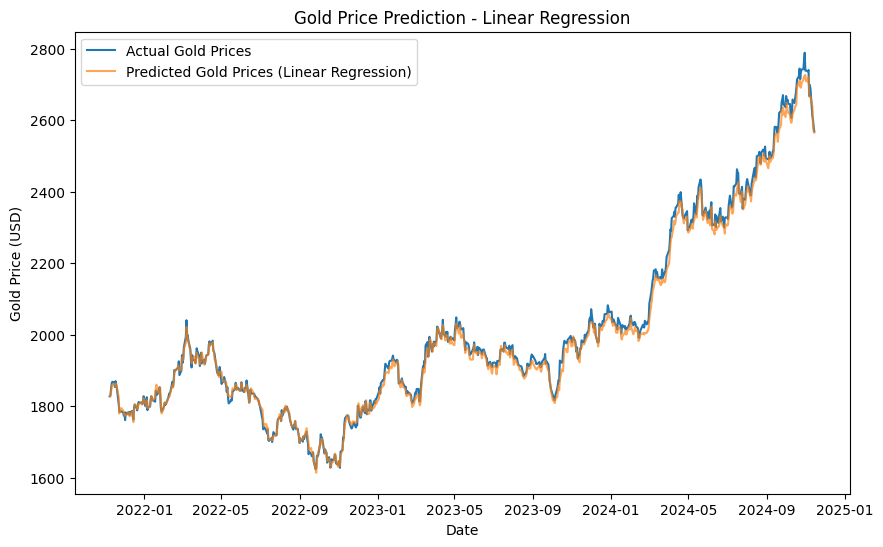

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)

print(f"Linear Regression - MAE: {lr_mae}, MSE: {lr_mse}, RMSE: {lr_rmse}")

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual Gold Prices')
plt.plot(y_test.index, lr_predictions, label='Predicted Gold Prices (Linear Regression)', alpha=0.7)
plt.legend()
plt.title('Gold Price Prediction - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.show()

In [15]:
from sklearn.metrics import r2_score
lr_r2 = r2_score(y_test, lr_predictions)

lr_accuracy = lr_r2 * 100
print(f"Linear Regression - R²: {lr_r2}, Accuracy: {lr_accuracy:.2f}%")

Linear Regression - R²: 0.996036151030439, Accuracy: 99.60%


Observation:

Linear regression performs surprisingly well for the given dataset, capturing trends and showing strong alignment with the actual gold prices.
The predictions align well with the data early on but tend to deviate during periods of high volatility.

Reasons:

Linear regression is likely performing well because it works well for simpler, linear relationships.
Early periods in the dataset may have consistent, linear patterns that are easier to model.
The deviations in later dates might arise from increased volatility, which linear regression cannot handle effectively due to its simplicity.

##### **Random Forest**

Random Forest - MAE: 154.30060855263145, MSE: 69932.80759342464, RMSE: 264.4481189069505


C:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


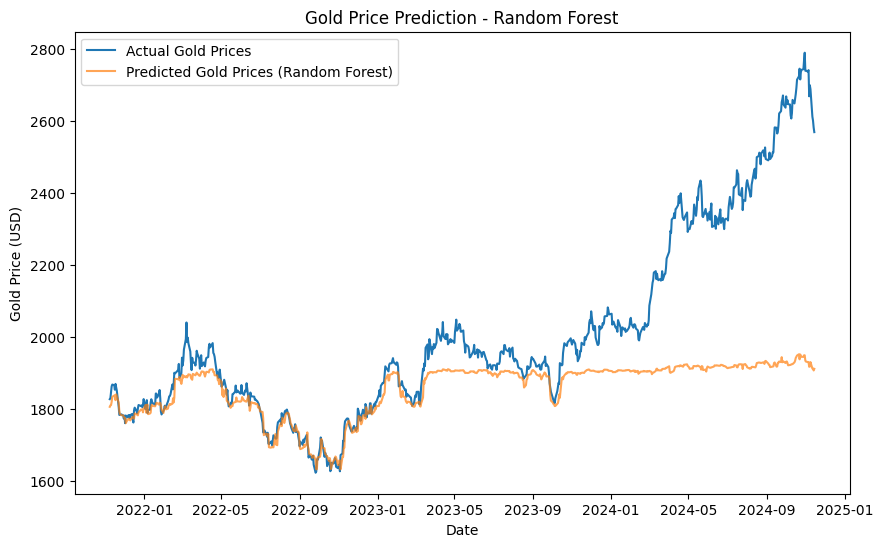

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}")

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual Gold Prices')
plt.plot(y_test.index, rf_predictions, label='Predicted Gold Prices (Random Forest)', alpha=0.7)
plt.legend()
plt.title('Gold Price Prediction - Random Forest')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.show()

##### **XGBoost**

C:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost - MAE: 187.9129143182052, MSE: 85918.29357078692, RMSE: 293.11822456269573


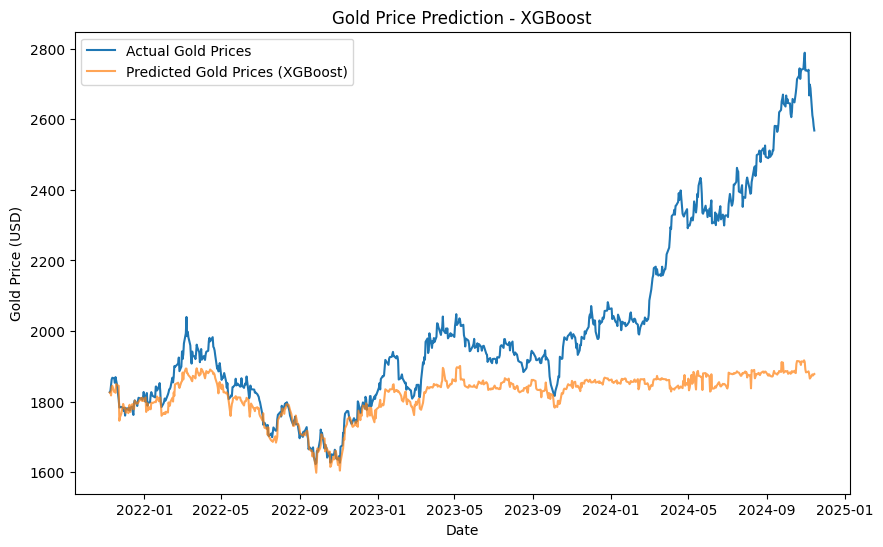

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

print(f"XGBoost - MAE: {xgb_mae}, MSE: {xgb_mse}, RMSE: {xgb_rmse}")

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual Gold Prices')
plt.plot(y_test.index, xgb_predictions, label='Predicted Gold Prices (XGBoost)', alpha=0.7)
plt.legend()
plt.title('Gold Price Prediction - XGBoost')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.show()

##### **LSTM**

In [20]:
# !pip install tensorflow

C:\python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 2008140.8750 - val_loss: 4071048.0000
Epoch 2/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1995644.0000 - val_loss: 4045716.7500
Epoch 3/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1959491.1250 - val_loss: 4019823.2500
Epoch 4/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1959584.2500 - val_loss: 3993899.5000
Epoch 5/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1914823.1250 - val_loss: 3965940.5000
Epoch 6/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1924209.7500 - val_loss: 3936047.5000
Epoch 7/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1901680.7500 - val_loss: 3908212.7500
Epoch 8/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1868836.0000 - val_loss: 3881163.5000
Epoch 9/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1865769.1250 - val_loss: 3852879.0000
Epoch 10/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1869837.1250 - val_loss: 3825927.7500
Epoch 11/500
48/48 

C:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


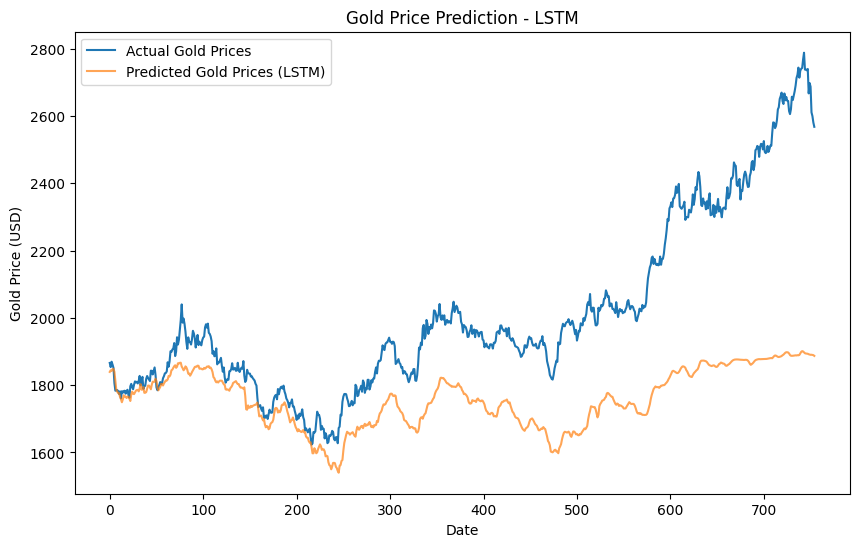

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Convert to float64 to ensure numeric type compatibility with TensorFlow
train_data = train_data.astype(np.float64)
test_data = test_data.astype(np.float64)

# Reshape the data for LSTM (we use a window of 5 previous days to predict the next)
def create_lstm_dataset(data, target_col, n_lags=5):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data.iloc[i-n_lags:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_lstm_dataset(train_data, 'GOLD_FUTURES')
X_test_lstm, y_test_lstm = create_lstm_dataset(test_data, 'GOLD_FUTURES')

# Reshape data to be 3D [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(LSTM(350, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))  # Predict gold price as output
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=500, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

lstm_predictions = lstm_model.predict(X_test_lstm)

from sklearn.metrics import mean_absolute_error, mean_squared_error
lstm_mae = mean_absolute_error(y_test_lstm, lstm_predictions)
lstm_mse = mean_squared_error(y_test_lstm, lstm_predictions)
lstm_rmse = mean_squared_error(y_test_lstm, lstm_predictions, squared=False)

print(f"LSTM - MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test_lstm, label='Actual Gold Prices')
plt.plot(lstm_predictions, label='Predicted Gold Prices (LSTM)', alpha=0.7)
plt.legend()
plt.title('Gold Price Prediction - LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.show()

LSTMs (Long Short-Term Memory networks) are well-suited for financial data due to their ability to handle sequential and non stationary data and capture temporal dependencies effectively. 

Observation:

The LSTM's predictions (orange line) show a general upward trend but fail to capture the sharp fluctuations and finer details of the actual gold price (blue line).
The predictions consistently lag the actual price movements and show a smoother, less dynamic curve.

Reasons:

* Limited training iterations: Training stopped at 500 iterations due to memory constraints, which might not have been enough for the model to converge fully.
* Data preparation: The fixed window size (e.g., 5 days) might not provide enough context for the LSTM to understand long-term trends.

Improvements:

* Train for more epochs if computational resources allow.
* Using a larger input window size (e.g., 30 or 60 days) to provide more historical context for the model.
* Introduce regularization techniques like dropout or L2 weight decay to prevent overfitting.
* Can consider reducing the number of features to focus on the most relevant ones.